<a href="https://colab.research.google.com/github/Sahar-Eissa/MachineLearning/blob/master/media_literacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!git clone https://github.com/fastai/course-v4 'drive/My Drive/course-v4'

fatal: destination path 'drive/My Drive/course-v4' already exists and is not an empty directory.


In [3]:
!pip install fastai2

     |████████████████████████████████| 184kB 14.1MB/s 


In [0]:
from fastai2 import *
!pip install graphviz ipywidgets matplotlib nbdev>=0.2.12 pandas scikit_learn 

In [0]:
from nbdev.showdoc import *
from ipywidgets import widgets
from pandas.api.types import CategoricalDtype


In [6]:
!pip install azure-cognitiveservices-search-imagesearch

     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 92kB 11.7MB/s 
     |████████████████████████████████| 40kB 3.5MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
     |████████████████████████████████| 61kB 11.1MB/s 
     |████████████████████████████████| 2.7MB 24.4MB/s 


In [0]:
from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth


In [8]:
from fastai2.vision.all import *
!pip install utils
from utils import *
from fastai2.vision.widgets import *

In [0]:
key = '173e7aa99dc34bdeabacd319ac5c4a92'

In [0]:
def search_images_bing(key, term, min_sz=128):
    client = api('https://api.cognitive.microsoft.com', auth(key))
    return L(client.images.search(query=term, count=150, min_height=min_sz, min_width=min_sz).value)


In [11]:
results = search_images_bing(key, 'beautiful girl kid')
ims = results.attrgot('content_url')
len(ims)


150

In [12]:
ims[0]

'https://i1.wp.com/childphotocompetition.com/wp-content/uploads/2014/07/Ashlyn-Mae-Photography.jpg?resize=640%2C960'

In [0]:
kids= 'beautiful girl', 'Handsome boy'


In [14]:
path = Path('media')
if not path.exists():
    path.mkdir()
    for o in kids:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} kid')
        download_images(dest, urls=results.attrgot('content_url'))

In [15]:
fns = get_image_files(path)
fns

(#298) [Path('media/beautiful girl/00000063.jpg'),Path('media/beautiful girl/00000141.jpg'),Path('media/beautiful girl/00000131.jpg'),Path('media/beautiful girl/00000001.jpg'),Path('media/beautiful girl/00000004.jpg'),Path('media/beautiful girl/00000111.jpg'),Path('media/beautiful girl/00000140.jpg'),Path('media/beautiful girl/00000128.jpg'),Path('media/beautiful girl/00000028.jpg'),Path('media/beautiful girl/00000108.jpg')...]

In [16]:
fns[0]

Path('media/beautiful girl/00000063.jpg')

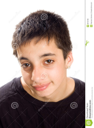

In [17]:
tosee = 'media/Handsome boy/00000075.jpg'
download_url(fns[0],tosee)
im = Image.open(tosee)
im.to_thumb(128,128)

In [18]:
failed = verify_images(fns)
failed

(#3) [Path('media/beautiful girl/00000113.jpg'),Path('media/Handsome boy/00000046.jpg'),Path('media/Handsome boy/00000072.jpg')]

In [0]:
failed.map(Path.unlink);

In [0]:
media_data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [0]:
dls= media_data.dataloaders(path)

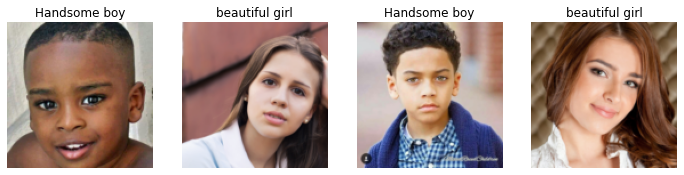

In [22]:
dls.valid.show_batch(max_n=4, nrows=1)

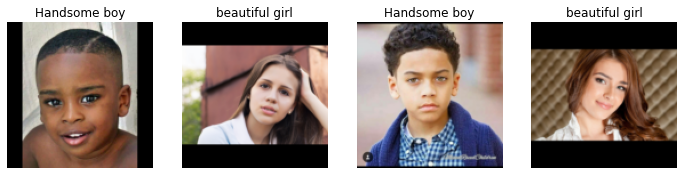

In [23]:
media_data = media_data.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = media_data.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

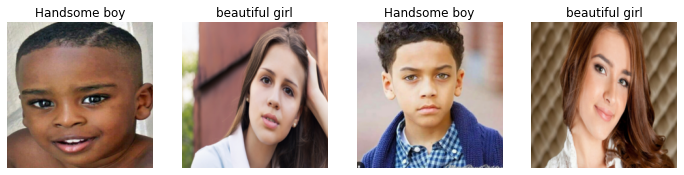

In [24]:
media_data = media_data.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = media_data.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)




In [25]:
learn= cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


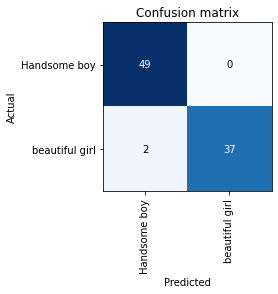

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

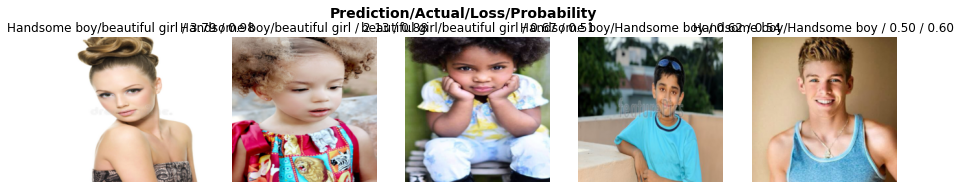

In [27]:
interp.plot_top_losses(5, nrows=1)

In [28]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [0]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()


In [0]:
learn.export()

In [41]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [0]:
learn_inf = load_learner(path/'export.pkl')


In [33]:
learn_inf.predict('media/Handsome boy/00000075.jpg')

('Handsome boy', tensor(0), tensor([9.9996e-01, 3.8131e-05]))

In [43]:
learn_inf.dls.vocab


(#2) ['Handsome boy','beautiful girl']